In [1]:
import cv2
import random
import time
import numpy as np
from scipy import misc

from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
import os
import sys
sys.path.append('../common/')
import utils

# 开始
## 首先读入所有图片

In [2]:
import pickle

## (IM_train,y_train,IM_test)三个矩阵的形状如下：
### IM_train:  58512个 (100 * 100 * 3 )的矩阵
### y_train:  58512个实数，代代表图片标签，0代表非人脸，1代表人脸
### IM_test:  200个( 250 * 250 * 3) 的矩阵

In [3]:
import pickle
with open('./xy.pkl','rb') as whdl:
    (IM_train,y_train,IM_test) = pickle.load(whdl)

# 看一些训练集中的图片，图片上的数字为图片的label

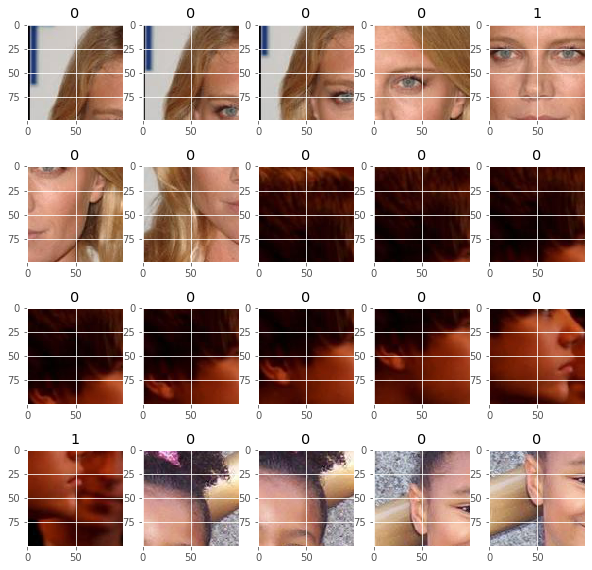

In [4]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i + 1)
    plt.imshow(IM_train[i * 10 ])
    plt.title(y_train[i * 10])

# 分别查看一张图片中的三个色道

In [5]:
img_demo = IM_train[0]

In [6]:
img_demo[:,:,0].shape

(100, 100)

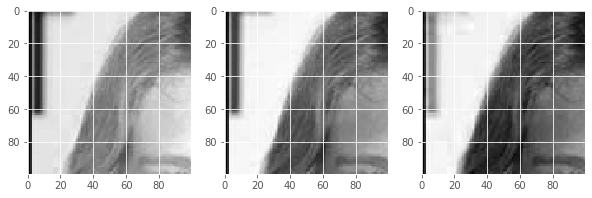

In [7]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.imshow(img_demo[:,:,i],cmap='gray')

# 使用直方图统计某一张训练图片的颜色分布

In [8]:
import pandas as pd

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb4842b750>]],
      dtype=object)

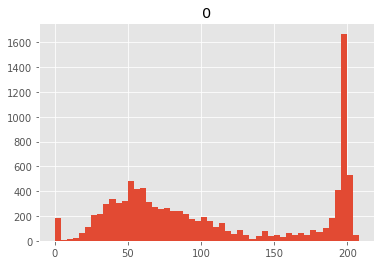

In [9]:
pd.DataFrame(img_demo[:,:,2].reshape(-1)).hist(bins=50)#(0~255) blue green red

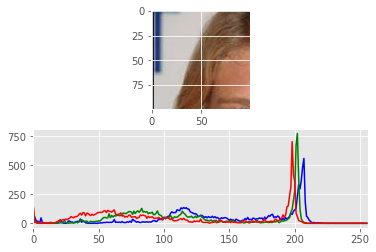

In [10]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[0])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[0]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

# 使用更少的bins生成颜色直方图

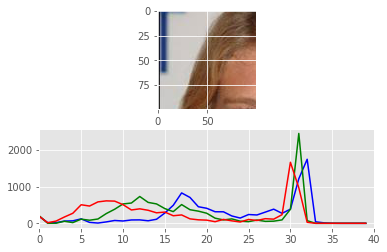

In [11]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[0])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[0]],[i],None,[40],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,40])
plt.show()

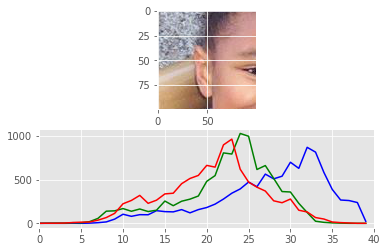

In [12]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[180])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[180]],[i],None,[40],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,40])
plt.show()

# 生成 feature


In [16]:
pb = utils.ProgressBar(worksum=len(IM_train))
pb.startjob()
features = []
targets = []
for one_image,one_target in zip(IM_train,y_train):
    one_feature = []
    if len(one_image.shape) != 3:
        continue
    for i,col in enumerate(color):
        histr = cv2.calcHist([one_image],[i],None,[40],[0,256]).T[0]
        one_feature.append(histr)
    one_feature = np.concatenate(one_feature) # (120)
    features.append(one_feature)
    targets.append(one_target)
    pb.complete(1)

 99.76 % [=================================================>-] 58371/58512 	 used:9s eta:0 s

In [17]:
# (40) (40) (40) -> (120)

# 经过提取之后的feature 的形状大小和feature可视化

In [18]:
features[0].shape

(120,)

In [19]:
len(features)

58371

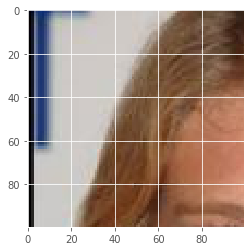

In [20]:
plt.imshow(IM_train[0])

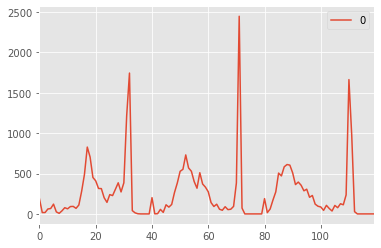

In [21]:
pd.DataFrame(features[0]).plot()

In [22]:
features[0].shape

(120,)

# 查看标签的分布

In [23]:
from collections import Counter
Counter(targets)

Counter({0: 55620, 1: 2751})

In [24]:
len(features),len(targets)

(58371, 58371)

In [25]:
train_x,val_x = features[:-10000], features[-10000:]
train_y,val_y = targets[:-10000], targets[-10000:]

In [26]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [27]:
lr = LogisticRegression()

In [28]:
lr_model = lr.fit(train_x,train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
val_pred = lr_model.predict_proba(val_x)[:,1]

In [30]:
val_pred

array([0.00126012, 0.00461285, 0.02554466, ..., 0.04327962, 0.09245974,
       0.13231521])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb08e73450>]],
      dtype=object)

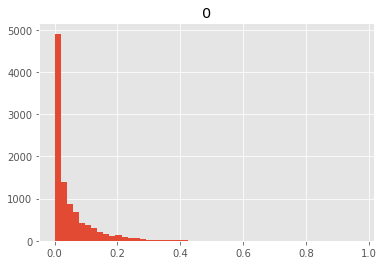

In [31]:
pd.DataFrame(val_pred).hist(bins=50)

In [32]:
from sklearn import metrics

In [33]:
 fpr, tpr, thresholds = metrics.roc_curve(val_y, val_pred, pos_label = 1)

In [34]:
metrics.auc(fpr, tpr)

0.8014728184144351

In [35]:
def get_feature(input_img):
    one_feature = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([input_img],[i],None,[40],[0,256]).T[0]
        one_feature.append(histr)
    one_feature = np.concatenate(one_feature)

    return one_feature

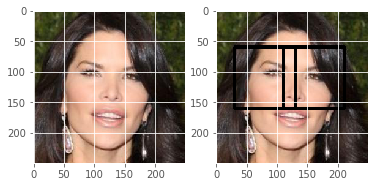

In [36]:

sample_image = np.copy(IM_test[2])
plt.subplot(1,2,1)
plt.imshow(sample_image)
for i in range(0,250 - 100,10):
    for j in range(0,250 - 100,10):
        one_feature = get_feature(sample_image[i:i + 100,j:j + 100])
        result = lr_model.predict_proba([one_feature])
        #print(result)
        if result[0][1] > 0.1:
            cv2.rectangle(sample_image,(i,j),(i + 100,j + 100),(0,0,0),3)
plt.subplot(1,2,2)
plt.imshow(sample_image)

# pickle 使用

In [37]:
import pickle

In [41]:
a = np.asarray([1,2,3])

In [39]:
?pickle.dump

Signature: pickle.dump(obj, file, protocol=None, *, fix_imports=True)
Docstring:
Write a pickled representation of obj to the open file object file.

This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
be more efficient.

The optional *protocol* argument tells the pickler to use the given
protocol supported protocols are 0, 1, 2, 3 and 4.  The default
protocol is 3; a backward-incompatible protocol designed for Python 3.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

The *file* argument must have a write() method that accepts a single
bytes argument.  It can thus be a file object opened for binary
writing, an io.BytesIO instance, or any other custom object that meets
this interface.

If *fix_imports* is True and protocol is less than 3, pickle will try
to map the new Python 3 names to the old module names used in Python
2, s

In [40]:
?pickle.load

Signature: pickle.load(file, *, fix_imports=True, encoding='ASCII', errors='strict')
Docstring:
Read and return an object from the pickle data stored in a file.

This is equivalent to ``Unpickler(file).load()``, but may be more
efficient.

The protocol version of the pickle is detected automatically, so no
protocol argument is needed.  Bytes past the pickled object's
representation are ignored.

The argument *file* must have two methods, a read() method that takes
an integer argument, and a readline() method that requires no
arguments.  Both methods should return bytes.  Thus *file* can be a
binary file object opened for reading, an io.BytesIO object, or any
other custom object that meets this interface.

Optional keyword arguments are *fix_imports*, *encoding* and *errors*,
which are used to control compatibility support for pickle stream
generated by Python 2.  If *fix_imports* is True, pickle will try to
map the old Python 2 names to the new names used in Python 3.  The
*encoding* a